# Create a script tool

With your Python code written, you can now modify it slightly to create a [script tool](https://pro.arcgis.com/en/pro-app/latest/arcpy/geoprocessing_and_python/a-quick-tour-of-creating-script-tools.htm). A script tool will allow anyone with ArcGIS Pro and the Spatial Analyst extension to run the Python script you created without any knowledge of Python or Notebooks. It will look and work like any other geoprocessing tool in ArcGIS.  

Converting a script to a script tool allows non-programmers to use your analysis workflow.

There are several steps to create a script tool:  

1. Modify the code to take inputs from the script tool.
2. Export the notebook's contents to a Python (.py) file. 
3. Create a toolbox.
4. Create a script tool in the toolbox. 
5. Set parameters for the tool.  
6. Document the tool.
7. Connect the tool to the Python script.
8. Run the tool.

### Modify the code for use in the script tool  

First, you will make a few modifications to allow the script tool to pass parameter values to the Python code. Once you've done that, you will export the modified code to a Python file and use that to create the script tool.

In the original script, you set several variables at the beginning of the code. These variables are `before_img_folder` and `after_img_folder,` which contain the locations of the folders containing the imagery to process, and `final_output_folder,` which contains the path to the folder where output files will be written. These variables must be changed to accept input when the script tool is run.  

The code from the previous notebook is included below. You'll edit it in this notebook, export the .py script from this notebook and continue following the instructions here to set up the script tool.

You will use the *[GetParameterAsText](https://pro.arcgis.com/en/pro-app/latest/arcpy/functions/getparameterastext.htm)* method to set these variables by passing in values from the script tool. To do this, you set the values of the three data path variables to be script parameters. The index value is used to match the value passed from the script tool to the script when it runs. The index numbers correspond to the order of the parameters in the GUI tool, from top to bottom, starting with an index value of 0, and increasing by one for each parameter. The first parameter in the Python script, with `arcpy.GetParameterAsText(0),` will get its value from the GUI tool's first parameter.

In the cell below, the lines to set the three variables have been commented out, and new lines, setting the variables using `GetParameterAsText(index value)`, have been added.  
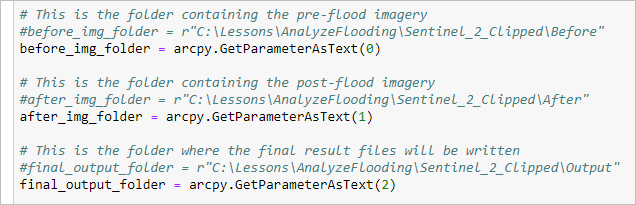

These are the only changes that must be made to the code to enable it to be used in a script tool.  

With this change, the code will not run correctly from the notebook, because the paths to the input and output folders are not defined. This information will be supplied through the script tool interface when the tool is run as a script tool.

In [ ]:
# Imports
import os
from glob import glob
import arcpy
from arcpy.sa import *

# Set the input and output folder location variables.
# These must point to the locations of the folders in the Sentinel_2_Clipped folder you extracted.
# The "r" prefixes to the path strings indicate that these are "raw" strings in Python, and 
# the \ characters should not be treated as an escape character. If you edit these paths, remember
# to keep the \Before, \After, and \Output folder names in the paths.

# This is the folder containing the pre-flood imagery
#before_img_folder = r"C:\Lessons\AnalyzeFlooding\Sentinel_2_Clipped\Before"
before_img_folder = arcpy.GetParameterAsText(0)

# This is the folder containing the post-flood imagery
#after_img_folder = r"C:\Lessons\AnalyzeFlooding\Sentinel_2_Clipped\After"
after_img_folder = arcpy.GetParameterAsText(1)

# This is the folder where the final result files will be written
#final_output_folder = r"C:\Lessons\AnalyzeFlooding\Sentinel_2_Clipped\Output"
final_output_folder = arcpy.GetParameterAsText(2)

def create_sen2_band_variables(in_folder):
    """A function that creates band variables for Sentinel-2 imagery given the folder with all the band images."""
    
    # Use arcpy.AddMessage like print() to print to the ArcGIS Geoprocessing messages
    arcpy.AddMessage("Creating variables for image bands...")

    # Get a list of the jpg2000 files in the input folder and store it in a list
    band_list = glob(in_folder + "/*.jp2")

    # Use list comprehension to get files in the band_list which correspond to the specific Sentinel-2 band file names
    Blue = [x for x in band_list if x.endswith("B02.jp2")][0]
    Green = [x for x in band_list if x.endswith("B03.jp2")][0]
    Red = [x for x in band_list if x.endswith("B04.jp2")][0]
    Red_Edge_1 = [x for x in band_list if x.endswith("B05.jp2")][0]
    NIR = [x for x in band_list if x.endswith("B08.jp2")][0]
    SWIR2 = [x for x in band_list if x.endswith("B12.jp2")][0]

    # Return the band variables
    return Blue, Green, Red, Red_Edge_1, NIR, SWIR2

# call the create_sen2_band_variables function on the folder containing the after imagery
after_Blue, after_Green, after_Red, after_Red_Edge_1, after_NIR, after_SWIR2 = create_sen2_band_variables(after_img_folder)

# print a couple bands to see the results
print(after_Red)  # print the path of the Red band
print(after_NIR)  # print the path of the NIR band

# create the composite image, storing the output in memory
arcpy.CompositeBands_management(in_rasters=f"{after_NIR};{after_Red};{after_Green}",
                                out_raster=r"memory\after_composite_img")

# creates SWI processor function
def swi_processor(red_edge1_band, swir2_band):
    """Create a function which calculates the SWI for the given input image."""
    
    arcpy.AddMessage("\nBegining SWI Calculation...")
    
    # Calculate the SWI - Sentinel-2 Water Index
    # SWI Formula = (Red_Edge1 - SWIR2) / (Red_Edge1 + SWIR2)
    
    # Create a variable to store the calculation for the numerator
    # using arcpy spatial analyst Float tool to create a raster with floating point cell values
    Numerator = arcpy.sa.Float(Raster(red_edge1_band) - Raster(swir2_band))
    
    # Create a variable to store the calculation for the denominator
    # using arcpy spatial analyst Float tool to create a raster with floating point cell values
    Denominator = arcpy.sa.Float(Raster(red_edge1_band) + Raster(swir2_band))
    
    # Use the arcpy spatial analyst Divide tool to divide the numerator and the denominator 
    SWI = arcpy.sa.Divide(Numerator, Denominator)

    # return the results
    return SWI
    
    arcpy.AddMessage("SWI Successfully Generated")

# creates NDWI processor function
def ndwi_processor(green_band, nir_band):
    """Create a function which calculates the NDWI for the given input image."""

    arcpy.AddMessage("\nBegining NDWI Calculation...")
    
    # Calculate the NDWI - Normalized Difference Water Index
    # NDWI Formula = (Green - NIR) / (Green + NIR)

    # Create a variable to store the calculation for the numerator
    # using arcpy spatial analyst Float tool to create a raster with floating point cell values
    Num = arcpy.sa.Float(Raster(green_band) - Raster(nir_band))
    
    # Create a variable to store the calculation for the denominator
    # using arcpy spatial analyst Float tool to create a raster with floating point cell values
    Denom = arcpy.sa.Float(Raster(green_band) + Raster(nir_band))
    
    # Use the arcpy spatial analyst Divide tool to divide the numerator and the denominator 
    NDWI = arcpy.sa.Divide(Num, Denom)
    
    # return the results
    return NDWI
    
    arcpy.AddMessage("NDWI Successfully Generated")

# Process SWI 
# Create the SWI raster
after_swi_calc = swi_processor(red_edge1_band=after_Red_Edge_1,
                               swir2_band=after_SWIR2)

# Create path for output SWI file
after_swi_raster = r"memory\after_swi_raster"

# Save the result
after_swi_calc.save(after_swi_raster)


# Process NDWI 
# Create the NDWI raster
after_ndwi_calc = ndwi_processor(green_band=after_Green,
                                 nir_band=after_NIR)

# Create path for output NDWI file
after_ndwi_raster = r"memory\after_ndwi_raster"

# Save the result
after_ndwi_calc.save(after_ndwi_raster)

def create_threshold_raster(in_raster):
    """Creates a function that thresholds the input raster, and then returns it."""
    
    # Run the Ostu thresholding function on the input raster
    thresh_calc = arcpy.sa.Threshold(in_raster)
    
    # Return the result
    return thresh_calc

# Process NDWI 
# Use the threshold_raster function to process the NDWI raster
after_ndwi_thresh_calc = create_threshold_raster(in_raster=after_ndwi_raster)

# Create a path for output NDWI file
after_ndwi_thresh_raster = r"memory\after_ndwi_thresh"

# Save the NDWI thresh raster
after_ndwi_thresh_calc.save(after_ndwi_thresh_raster)

# Create a raster layer for the NDWI threshold file so it can be viewed in the results map tab
after_ndwi_threshold_layer = arcpy.MakeRasterLayer_management(after_ndwi_thresh_raster, 'after_ndwi_threshold')


# Process SWI 
# Use the threshold_raster function to process the SWI raster
after_swi_thresh_calc = create_threshold_raster(in_raster=after_swi_raster)

# Create a path for output NDWI file
after_swi_thresh_raster = r"memory\after_swi_thresh"

# Save the SWI thresh raster
after_swi_thresh_calc.save(after_swi_thresh_raster)

# Create a raster layer for the SWI threshold file so it can be viewed in the results map tab
after_swi_threshold_layer = arcpy.MakeRasterLayer_management(after_swi_thresh_raster, 'after_swi_threshold')

def create_water_confidence_raster(ndwi_threshold_raster, swi_threshold_raster):
    """Create a function that calculates the sum of two rasters."""
    
    # Add the two threshold rasters together by creating raster objects of each and combining them using the addition + operator
    water_confidence_raster = Raster(ndwi_threshold_raster) + Raster(swi_threshold_raster)

    # Return the result
    return water_confidence_raster

# Call the create_water_confidence_raster function
after_water_confidence_raster = create_water_confidence_raster(ndwi_threshold_raster=after_ndwi_thresh_raster, 
                                                         swi_threshold_raster=after_swi_thresh_raster)

# Create a path for output water confidence raster file
after_water_confidence_raster_path = r"memory\after_water_confidence_raster"

# Save the water confidence raster to a file in memory
after_water_confidence_raster.save(after_water_confidence_raster_path)

# Create a raster layer for the confidence raster file so it can be viewed in the results map tab
# after_water_confidence_matrix_layer = arcpy.MakeRasterLayer_management(after_water_confidence_raster, 'after_water_confidence_matrix')

# Create the remap values to set any pixels with the value of 1 to 0.
remap_value = RemapValue([[1, 0]])

# Reclassify the water mask
after_water_mask_reclass = Reclassify(in_raster=after_water_confidence_raster_path, 
                                      reclass_field="value", 
                                      remap=remap_value)

# Create a path for output water mask file
after_water_mask_raster = r"memory\after_water_mask_high_confidence"

# Save the water mask
after_water_mask_reclass.save(after_water_mask_raster)

# Create a raster layer so it can be viewed in the results map tab.
#after_water_mask_layer = arcpy.MakeRasterLayer_management(after_water_mask_reclass, 'after_water_mask_high_confidence')

# Step 1: create the band variables 
before_Blue, before_Green, before_Red, before_Red_Edge_1, before_NIR, before_SWIR2 = create_sen2_band_variables(
    in_folder=before_img_folder)


# Step 2: Create a false-color infrared composite image 
# create a composite image, storing the output in memory
arcpy.CompositeBands_management(in_rasters=f"{before_NIR};{before_Red};{before_Green}",
                                out_raster=r"memory\before_composite_img")

# Step 3: create indices 
# create the SWI raster
before_swi_calc = swi_processor(red_edge1_band=before_Red_Edge_1,
                                swir2_band=before_SWIR2)

# create path for output NDWI file
before_swi_raster = r"memory\before_swi_raster"

# Save result to file
before_swi_calc.save(before_swi_raster)

# create a raster layer for the NDWI threshold file so it can be viewed in the results map tab.
before_swi_layer = arcpy.MakeRasterLayer_management(before_swi_raster, 'before_swi')

# create the NDWI raster
before_ndwi_calc = ndwi_processor(green_band=before_Green,
                                  nir_band=before_NIR)

# create path for output NDWI file
before_ndwi_raster = r"memory\before_ndwi_raster"

# Save result to file
before_ndwi_calc.save(before_ndwi_raster)

# create a raster layer for the NDWI threshold file so it can be viewed in the results map tab.
before_ndwi_layer = arcpy.MakeRasterLayer_management(before_ndwi_raster, 'before_ndwi')


# Step 4: threshold indices 
# Threshold for NDWI
before_ndwi_thresh_calc = create_threshold_raster(in_raster=before_ndwi_raster)

# create path for output NDWI file
before_ndwi_thresh_raster = r"memory\before_ndwi_thresh"

# save the NDWI thresh raster
before_ndwi_thresh_calc.save(before_ndwi_thresh_raster)

# create a raster layer for the NDWI threshold file so it can be viewed in the results map tab.
before_ndwi_threshold_layer = arcpy.MakeRasterLayer_management(before_ndwi_thresh_raster, 'before_ndwi_threshold')

# Threshold for SWI
before_swi_thresh_calc = create_threshold_raster(in_raster=before_swi_raster)

# create path for output SWI file
before_swi_thresh_raster = r"memory\before_swi_thresh"

# save the SWI thresh raster
before_swi_thresh_calc.save(before_swi_thresh_raster)

# create a raster layer for the SWI threshold file so it can be viewed in the results map tab.
before_swi_threshold_layer = arcpy.MakeRasterLayer_management(before_swi_thresh_raster, 'before_swi_threshold')


# Step 5: calculate confidence raster 
# create water confidence raster
before_water_confidence_raster = create_water_confidence_raster(ndwi_threshold_raster=before_ndwi_thresh_raster,
                                                                swi_threshold_raster=before_swi_thresh_raster)

# create path for output water confidence matrix file
before_water_confidence_raster_path = r"memory\before_water_confidence_raster"

# save the water confidence matrix to a file in memory
before_water_confidence_raster.save(before_water_confidence_raster_path)

# create a raster layer for the NDWI threshold file so it can be viewed in the results map tab.
# before_water_confidence_layer = arcpy.MakeRasterLayer_management(before_water_confidence_raster, 'before_water_confidence_raster')

# Step 6: extract water pixels 
# create the remap value to set any pixels with the value of 1 to 0.
remap_value = RemapValue([[1, 0]])

# reclassify the water mask
before_water_mask_reclass = Reclassify(in_raster=before_water_confidence_raster_path,
                                       reclass_field="value",
                                       remap=remap_value)

# create path for output water mask file
before_water_mask_raster = r"memory\before_water_mask_high_confidence"

# save the water mask to
before_water_mask_reclass.save(before_water_mask_raster)

# Using raster objects, subtract the before water mask from the after water mask
flooded_area_calc = Raster(after_water_mask_reclass) - Raster(before_water_mask_reclass)

# Create a path for flooded_area_calc
flooded_area_calc_raster = r"memory\flooded_area_calc"

# Save the flooded_area_calc raster
flooded_area_calc.save(flooded_area_calc_raster)

# Reclassify the final flood area 

# Create the remap values lists
remap_value_final = RemapValue([[-2, "NoData"], [0, "NoData"]])

# Reclassify the water mask
flooded_area_final = Reclassify(in_raster=flooded_area_calc, 
                                reclass_field="value", 
                                remap=remap_value_final)

# Create path for output flooded area tif file
flooded_area_final_raster = os.path.join(final_output_folder, "Flooded_Area_Final_Raster.tif")

# Save the final flooded area to a tif file
flooded_area_final.save(flooded_area_final_raster)

# Create path for output flooded area polygon file
flooded_area_final_poly = os.path.join(final_output_folder, "Flooded_Area_Final_Poly.shp")

# Convert to polygon
arcpy.RasterToPolygon_conversion(in_raster=flooded_area_final, 
                                 out_polygon_features=flooded_area_final_poly, 
                                 simplify="NO_SIMPLIFY", 
                                 raster_field="Value")
'''
# Get the currently open ArcGIS Pro Project
aprx = arcpy.mp.ArcGISProject("current")
# Get the map
m = aprx.listMaps("Map")[0]
# Get a list of the layers on the map
thelyrs = m.listLayers()
# Check each layer to determine if it is a temporary, in memory layer, 
# and remove the layer if it is.
for lyr in thelyrs:
    print(lyr.dataSource)
    if "INSTANCE_ID=GPProMemoryWorkspace" in lyr.dataSource:
        print("Removing: ", lyr.name )
        m.removeLayer(lyr)
'''        




### Export the code to a Python script file  

To use this code with a script tool, you must export it to a Python (.py) file.

1. On the ribbon, click the `Notebook` tab.
2. Click the **Export** drop-down menu and click **Export to Python File**.
3. Browse to the *C:\Lessons\AnalyzeFlooding* folder, name the Python file Flood_Analysis_Tool.py, and click **Save**. 

### Create a toolbox for the script tool  

Script tools are stored in toolboxes. Once you have exported the code to a Python file, the next step is to create a toolbox where you will store your script tool.

1. On the ribbon, click the **View** tab and click **Catalog Pane**.
2. In the **Catalog** pane, right-click **Folders**, and click **Add Folder Connection**.  
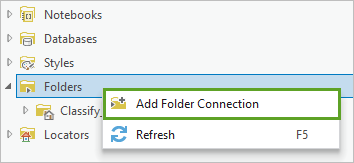


3. Browse to the *C:\Lessons\AnalyzeFlooding* folder, where you saved the **Flood_Analysis_Tool.py** file, and click **OK**.  

A folder connection is added to your project. You will create the toolbox here.  

4. In the **Catalog** pane, right-click the folder, click **New**, and click **Toolbox (.atbx)**.  
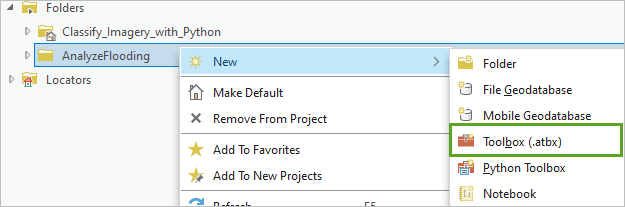

5. Expand the folder connection.  

6. Right-click **New Toolbox.atbx** and click **Rename**.  

7. Type Custom_Tools for the toolbox name and press _Enter_.


### Create a script tool  

Next, you will create the [script tool](https://pro.arcgis.com/en/pro-app/latest/arcpy/geoprocessing_and_python/a-quick-tour-of-creating-script-tools.htm) in the toolbox. Script tools allow you to run your Python scripts from a graphical interface like any other ArcGIS geoprocessing tool.  

While editing the script tool properties, you will not be able to scroll this notebook window. You can save settings in the script tool properties window by clicking **OK** at the bottom of the window. You can reopen the script tool properties by right-clicking the script tool in the toolbox and clicking **Properties**. It may be helpful to copy the instructions from the cells below into a text file or word processing document so you can see them in another window while you work.

1. In the **Catalog** pane, right-click the **Custom_Tools** toolbox, click **New**, and click **Script**.  
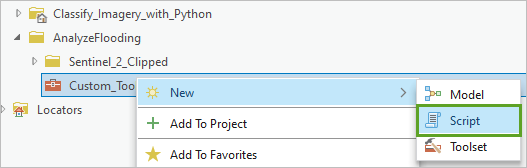


The **New Script** window appears.  

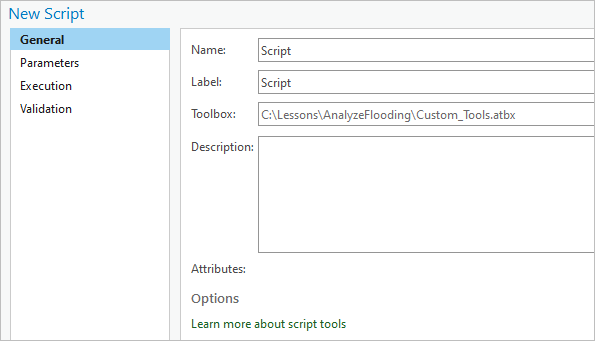

### Configure the script tool  

The **New Script** properties window has several tabs. You'll configure the script tool **Name**, **Label**, and **Description** values first.

1. On the **General** tab of the **New Script** properties window, for **Name**, type FloodAnalysisTool.  
The script tool **Name** cannot include any spaces or non-letter characters.  

2. For **Label**, type Flood Analysis Tool.  
The script tool **Label** is a display label for the tool and can contain spaces.

3. For **Description**, type This tool will classify and extract water from before and after images. It will then calculate the change in order to quantify the areas flooded after a flood event. This tool is for use with multi-spectral Sentinel-2 imagery.  

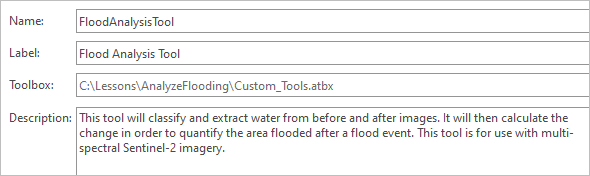

4. Click **Parameters**.  
The **Parameters** tab contains a table where you will set the three parameters that the script requires. For each parameter you add, you will specify the **Label**, **Name**, and **Data Type** settings of the parameter.

5. On the **Parameters**, tab, in the **Label** column, for the first (0) row, type Before Image Folder.  

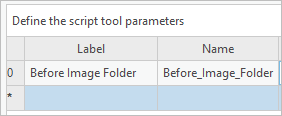  

The **Label** value will be the label for this parameter on the script tool 

The **Name** column contains the **Label** text without spaces.  The **Name** is the parameter name for using the tool with Python.

6. In the **Data Type** column for the first (0) row, point to the space to the right of **String**.  
7.  Click the **Change Data Type** button.
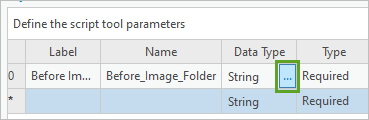  


8. In the **Parameter Data Type** window, click the dropdown list and choose **Folder**.  
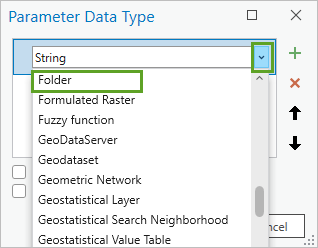  

9. Click **OK**.  

Geoprocessing tools can have many different types of inputs and outputs.  The flood area classification script takes two folders as inputs and writes the output to a third folder, so you will set the data type to **Folder** for each parameter. 

10. On the Parameters, tab, in the **Label** column, for the second row, type After Image Folder.  
11. Set the **Data Type** to **Folder**.  

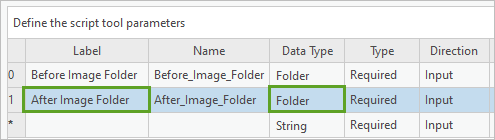

12. On the Parameters, tab, in the **Label** column, for the third row, type Final Output Folder.  
13. Set the **Data Type** to **Folder**.  

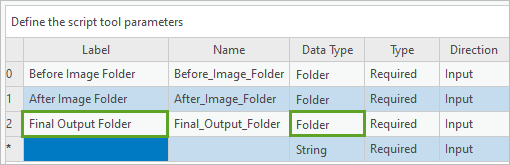


The order of the parameters is important. The order in this table must match the order you set in the Python script, using arcpy.GetParameterAsText. In this case the variable `before_img_folder` is set to the first parameter, `after_img_folder` is set to the second parameter, and `final_output_folder` is set to the third parameter.  

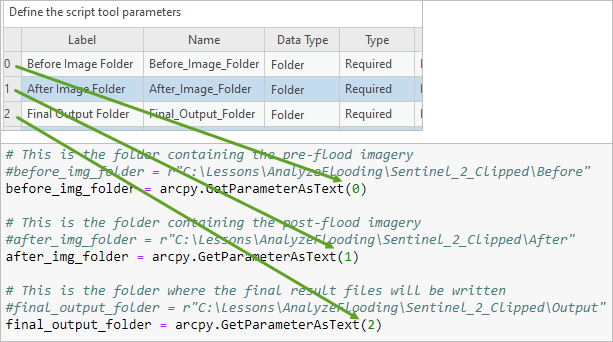

Now that you have set the script tool parameters, you can open the tool and see how it looks.
14. At the bottom of the properties window, click **OK**.  
This saves the properties you've set.  

15. In the **Catalog** pane, double-click the **Flood Analysis Tool**.

The script tool opens. It has the input parameters you specified.  The top of the tool shows the label text you set on the **General** tab, in the **Label** box.  The input parameters are labeled with the labels you set on the **Parameters** tab.
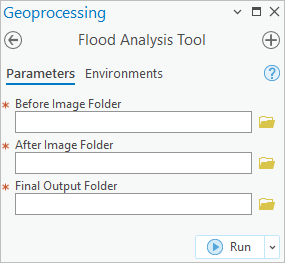  

The tool won't run yet because it hasn't been linked to the Python script file. You will add some documentation to the tool, then connect it to the script.  
16. Close the **Flood Analysis Tool**.


### Document the tool  

It is important to add documentation to your script tool, so other people will understand how to use it.  

1. In the **Contents** pane, right-click **Flood Analysis Tool** and click **Edit Metadata**.

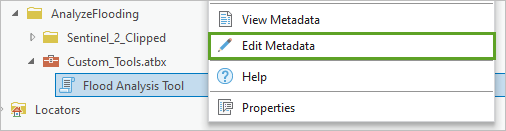  

The **Metadata** tab appears.

First, you will add tags.  

2. In the **Tags** box, add Flood, Water, Analysis.  

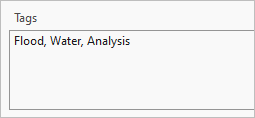

3. Scroll down to the **Syntax** section.

4. In the **Syntax** section, click **Before_Image_Folder**.  

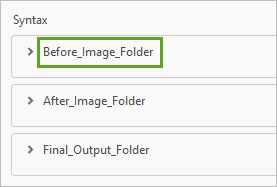  

The section expands.

5. In the **Dialog Explanation** box, type, This is the folder that contains the pre-flood imagery. This tool requires Sentinel-2 imagery which has not been composited into a single raster image with multiple bands. Instead, it requires each band as a separate image file, as it typically is available for download.  

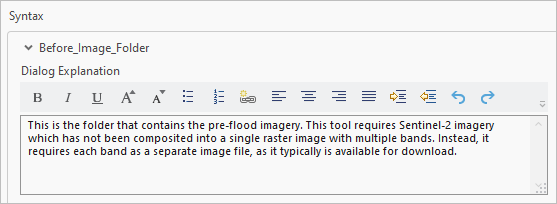


6. Click **After_Image_Folder**.  
7. In the **Dialog Explanation** box, type This is the folder that contains the post-flood imagery. This tool requires Sentinel-2 imagery which has not been composited into a single raster image with multiple bands. Instead, it requires each band as a separate image file, as it typically is available for download.

8. Click **Final_Output_Folder**.  
7. In the **Dialog Explanation** box, type This is the folder where the final outputs will be saved.

10. On the ribbon, on the **Metadata** tab, in the **Manage Metadata** section, click **Save**.  

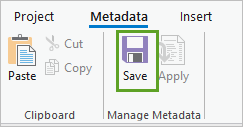


12. Close the **Flood Analysis Tool** metadata editing tab.  
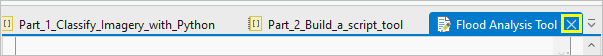

### Connect the tool to the Python script  

The final step to make the tool usable is to connect the script tool that you've configured to the Python script file you exported.  

1. In the **Catalog** pane, right-click the **Flood Analysis Tool** and click **Properties**.

2. Click the **Execution** tab.  
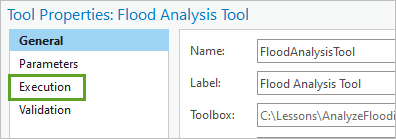


3. Click the browse button.  

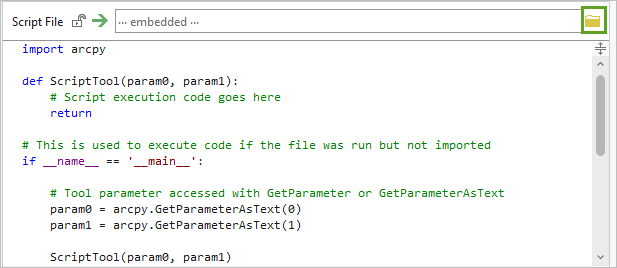

4. Browse to the **C:\Lessons\AnalyzeFlooding** folder where you saved the **Flood_Analysis_Tool.py** script file.  

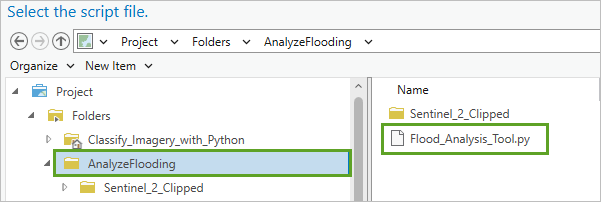  

5. Click **Flood_Analysis_Tool.py** and click **OK**.

The sample code in the **Script File** pane is replaced with the code from the **Flood_Analysis_Tool.py** script.  

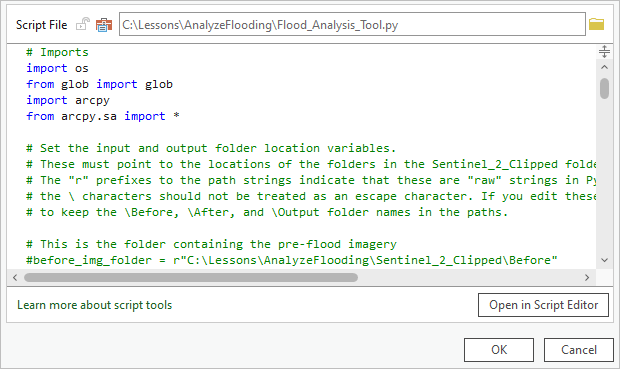

6. Click **OK**.

Now the script tool is set up to work by referencing the **Flood_Analysis_Tool.py** file from its location on your hard drive. This is good for testing, and for when you do not plan to share the script tool. However, if you plan to share this tool with someone else, you would send both the toolbox with the script tool and the Python file in the current folder structure.  

A more convenient method for sharing tools is to embed the code in the script tool. To do this, click the toolbox button next to the **Script File** path.  
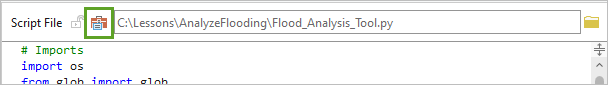

This saves the code in the toolbox, so you can share the toolbox alone, and the tool runs without needing the Python file.

### Run the tool  

Now that you have finished setting up the tool, you can run it.  

1. In the **Catalog** pane, double-click **Flood Analysis Tool**.  
2. For **Before Image Folder** click the browse button.  
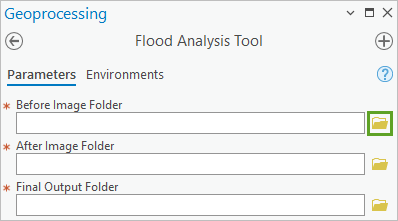

3. Browse to the **C:\Lessons\AnalyzeFlooding\Sentinel_2_Clipped** folder, click **Before**, and click **OK**.  
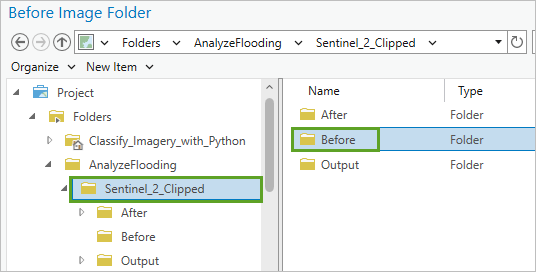


 4. For **After Image Folder**, click the browse button and browse to the **After** folder.  
 5. For **Final Output Folder**, click the browse button and browse to the **Output** folder.  
 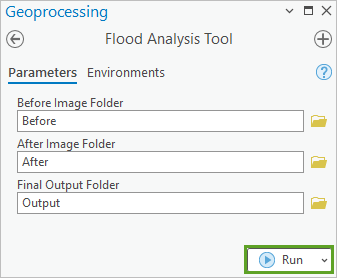  
 6. Click **Run**.  
 
 The tool will take some time to run.  When it finishes, the tool will indicate that it has run successfully.

7. In the **Catalog** pane, browse to the **Output** folder.  
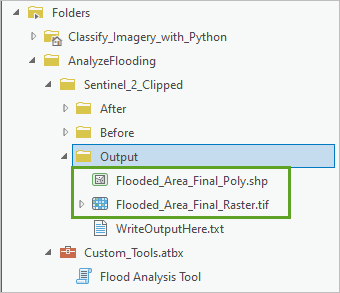  

The **Flooded_Area_Final_Poly.shp** and **Flooded_Area_Final_Raster.tif**  files are added to the **Output** folder.

You have created a script tool from a notebook.